
... ***CURRENTLY UNDER DEVELOPMENT*** ...


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.alr import ALR_WRP
from teslakit.util.time_operations import xds_reindex_daily, xds_common_dates_daily

from teslakit.plotting.estela import Plot_DWTs_Probs
from teslakit.plotting.wts import Plot_Probs_WT_WT
from teslakit.plotting.waves import Plot_Waves_DWTs



## Database and Site parameters

In [2]:
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')


In [3]:
# --------------------------------------
# load data and set parameters

MJO_fit = db.Load_MJO_hist()       # historical MJO
KMA_fit = db.Load_ESTELA_KMA()     # ESTELA + TCs Predictor
PCs_all = db.Load_SST_PCA()        # SST PCs (annual)

MJO_sim = db.Load_MJO_sim()        # MJO simulation (daily)
PCs_sim = db.Load_SST_PCs_sim_d()  # SST PCs simulation (daily)

# select MJO and PCs simulation
MJO_sim = MJO_sim.sel(n_sim=0)
PCs_sim = PCs_sim.sel(n_sim=0)

# ALR fit parameters
alr_num_clusters = 42
alr_markov_order = 1
alr_seasonality = [2, 4]

# ALR simulation
num_sims = 1



## ESTELA Predictor - Autoregressive Logistic Regression Fitting

In [4]:
# --------------------------------------
# Data used to FIT ALR model and preprocess: 

# KMA: bmus (daily) (use sorted_bmus_storms, add 1 to get 1-42 bmus set)
BMUS_fit = xr.Dataset(
    {
        'bmus':(('time',), KMA_fit['sorted_bmus_storms'].values[:] + 1),
    },
    coords = {'time': KMA_fit.time.values[:]}
)


# MJO: rmm1, rmm2 (daily)
print(MJO_fit)

# SST: PCs (annual)
sst_PCs = PCs_all.PCs.values[:]
PCs_fit = xr.Dataset(
    {
        'PC1': (('time',), sst_PCs[:,0]),
        'PC2': (('time',), sst_PCs[:,1]),
        'PC3': (('time',), sst_PCs[:,2]),
    },
    coords = {'time': PCs_all.time.values[:]}
)

# reindex annual data to daily data
PCs_fit = xds_reindex_daily(PCs_fit)
print(PCs_fit)


<xarray.Dataset>
Dimensions:  (time: 14343)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-04-08
Data variables:
    phase    (time) int64 ...
    rmm1     (time) float64 ...
    rmm2     (time) float64 ...
    mjo      (time) float64 ...
<xarray.Dataset>
Dimensions:  (time: 49674)
Coordinates:
  * time     (time) datetime64[ns] 1880-06-01 1880-06-02 ... 2016-06-01
Data variables:
    PC1      (time) float64 7.972 7.972 7.972 7.972 ... 55.53 55.53 55.53 -7.664
    PC2      (time) float64 1.668 1.668 1.668 1.668 ... 7.856 7.856 7.856 35.98
    PC3      (time) float64 -7.23 -7.23 -7.23 -7.23 ... 3.494 3.494 3.494 -9.33


In [5]:
# --------------------------------------
# Data used to SIMULATE ALR model and preprocess

# MJO: rmm1, rmm2 (daily data)
print(MJO_sim)

# SST: PCs (daily data)
print(PCs_sim)


<xarray.Dataset>
Dimensions:      (time: 365243)
Coordinates:
  * time         (time) object 1700-01-01 00:00:00 ... 2700-01-01 00:00:00
Data variables:
    mjo          (time) float32 ...
    phase        (time) float32 ...
    rmm1         (time) float32 ...
    rmm2         (time) float32 ...
    evbmus_sims  (time) float32 ...
Attributes:
    source:   teslakit_v0.9.1
<xarray.Dataset>
Dimensions:     (time: 365608)
Coordinates:
  * time        (time) object 1699-06-01 00:00:00 ... 2700-06-01 00:00:00
Data variables:
    PC1         (time) float32 ...
    PC2         (time) float32 ...
    PC3         (time) float32 ...
    evbmus_sim  (time) float32 ...
Attributes:
    source:   teslakit_v0.9.1


In [6]:
# --------------------------------------
# Mount covariates matrix

# available data:
# model fit: BMUS_fit, MJO_fit, PCs_fit
# model sim: MJO_sim, PCs_sim


# covariates_fit dates
d_fit = xds_common_dates_daily([MJO_fit, PCs_fit, BMUS_fit])

# KMA dates
BMUS_fit = BMUS_fit.sel(time = slice(d_fit[0], d_fit[-1]))

# PCs covars 
cov_PCs = PCs_fit.sel(time = slice(d_fit[0], d_fit[-1]))
cov_1 = cov_PCs.PC1.values.reshape(-1,1)
cov_2 = cov_PCs.PC2.values.reshape(-1,1)
cov_3 = cov_PCs.PC3.values.reshape(-1,1)

# MJO covars
cov_MJO = MJO_fit.sel(time = slice(d_fit[0], d_fit[-1]))
cov_4 = cov_MJO.rmm1.values.reshape(-1,1)
cov_5 = cov_MJO.rmm2.values.reshape(-1,1)

# join covars 
cov_T = np.hstack((cov_1, cov_2, cov_3, cov_4, cov_5))

# normalize
cov_norm_fit = (cov_T - cov_T.mean(axis=0)) / cov_T.std(axis=0)
cov_fit = xr.Dataset(
    {
        'cov_norm': (('time','n_covariates'), cov_norm_fit),
        'cov_names': (('n_covariates',), ['PC1','PC2','PC3','MJO1','MJO2']),
    },
    coords = {'time': d_fit}
)
print(cov_fit)


# covariates: SIMULATION
d_sim = xds_common_dates_daily([MJO_sim, PCs_sim])


# PCs covar 
cov_PCs = PCs_sim.sel(time = slice(d_sim[0], d_sim[-1]))
cov_1 = cov_PCs.PC1.values.reshape(-1,1)
cov_2 = cov_PCs.PC2.values.reshape(-1,1)
cov_3 = cov_PCs.PC3.values.reshape(-1,1)

# MJO covars
cov_MJO = MJO_sim.sel(time = slice(d_sim[0], d_sim[-1]))
cov_4 = cov_MJO.rmm1.values.reshape(-1,1)
cov_5 = cov_MJO.rmm2.values.reshape(-1,1)

# join covars (do not normalize simulation covariates)
cov_T_sim = np.hstack((cov_1, cov_2, cov_3, cov_4, cov_5))
cov_sim = xr.Dataset(
    {
        'cov_values': (('time','n_covariates'), cov_T_sim),
    },
    coords = {'time': d_sim}
)
print(cov_sim)


<xarray.Dataset>
Dimensions:    (n_covariates: 5, time: 13625)
Coordinates:
  * time       (time) datetime64[ns] 1979-02-12 1979-02-13 ... 2016-06-01
Dimensions without coordinates: n_covariates
Data variables:
    cov_norm   (time, n_covariates) float64 -0.1931 0.6627 ... -0.9324 0.3328
    cov_names  (n_covariates) <U4 'PC1' 'PC2' 'PC3' 'MJO1' 'MJO2'
<xarray.Dataset>
Dimensions:     (n_covariates: 5, time: 365243)
Coordinates:
  * time        (time) object 1700-01-01 1700-01-02 ... 2699-12-31 2700-01-01
Dimensions without coordinates: n_covariates
Data variables:
    cov_values  (time, n_covariates) float32 -9.213159 -0.14017779 ... 0.280497


In [7]:
# --------------------------------------
# Autoregressive Logistic Regression

# available data:
# model fit: BMUS_fit, cov_fit, num_clusters
# model sim: cov_sim, sim_num, sim_years

# ALR terms
d_terms_settings = {
    'mk_order'  : alr_markov_order,
    'constant' : True,
    'long_term' : False,
    'seasonality': (True, alr_seasonality),
    'covariates': (True, cov_fit),
}

# ALR wrapper
ALRW = ALR_WRP(db.paths.site.ESTELA.alrw)
ALRW.SetFitData(alr_num_clusters, BMUS_fit, d_terms_settings)

# ALR model fitting
ALRW.FitModel(max_iter=50000)



Fitting autoregressive logistic model ...
Optimization done in 80.70 seconds



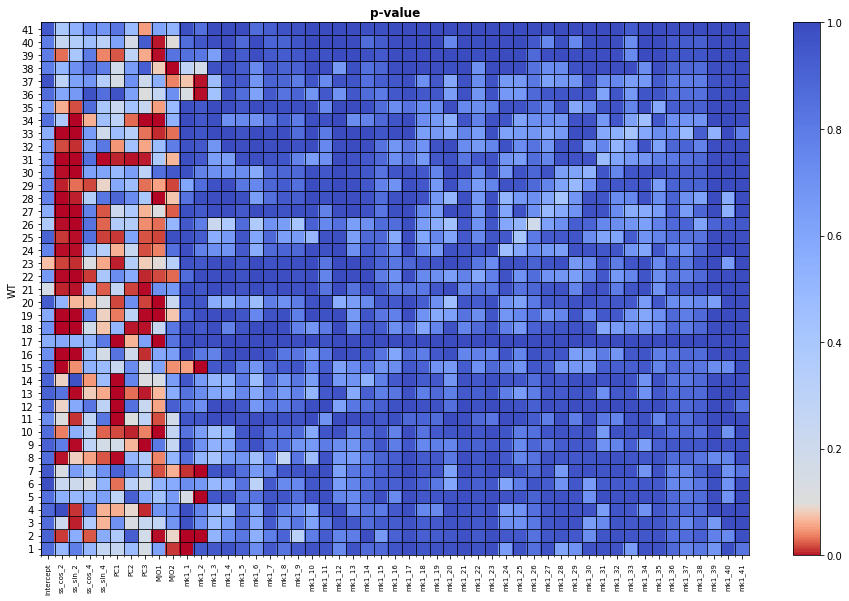

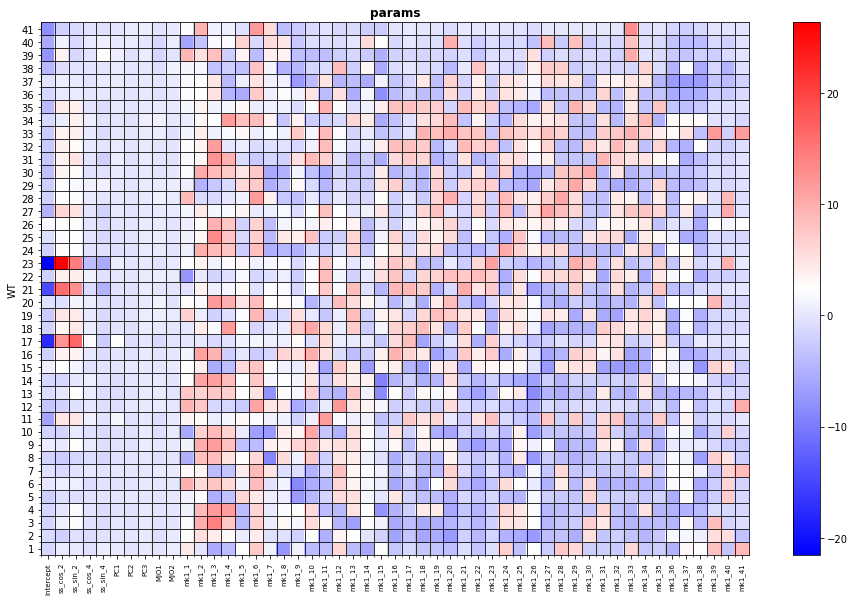

In [8]:
# Plot model p-values and params
ALRW.Report_Fit()



## ESTELA Predictor - Autoregressive Logistic Regression Simulation

In [9]:
# --------------------------------------
# Autoregressive Logistic Regression - simulate 

# launch simulation
xds_alr = ALRW.Simulate(num_sims, d_sim, cov_sim)

# Store Daily Weather Types
DWT_sim = xds_alr.evbmus_sims.to_dataset()
db.Save_ESTELA_DWT_sim(DWT_sim)

print(DWT_sim)


ALR model fit   : 1979-02-12 --- 2016-06-01
ALR model sim   : 1700-01-01 --- 2700-01-01

Launching 1 simulations...

Sim. Num. 001: 100%|██████████| 365242/365242 [16:15<00:00, 374.54it/s]

<xarray.Dataset>
Dimensions:      (n_sim: 1, time: 365243)
Coordinates:
  * time         (time) object 1700-01-01 1700-01-02 ... 2699-12-31 2700-01-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) int64 27 10 19 19 19 19 14 ... 34 34 28 28 28 28
Attributes:
    source:   teslakit_v0.9.1


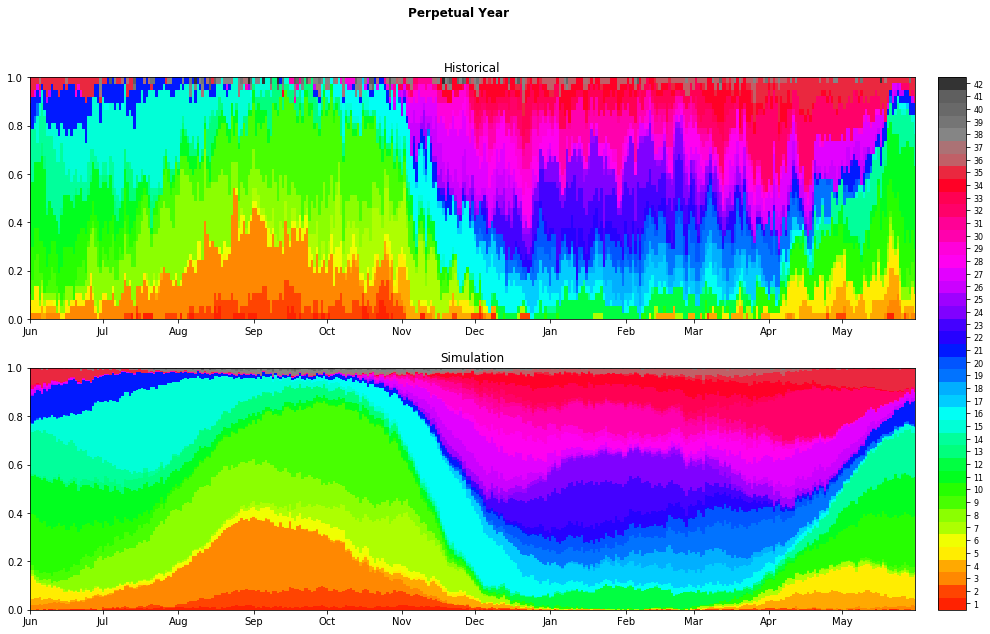

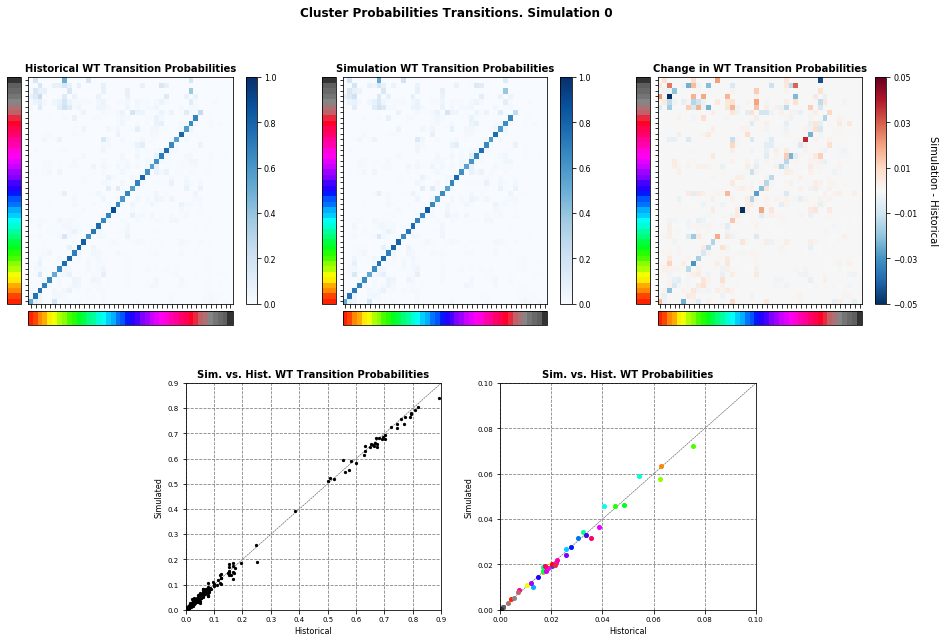

In [10]:
# show sim report
ALRW.Report_Sim(py_month_ini=6);


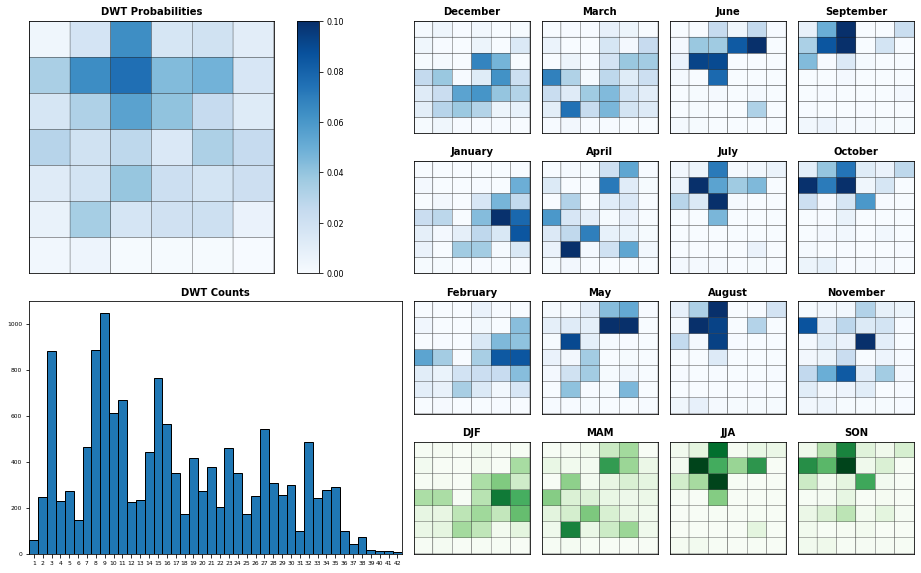

In [11]:
# Plot Historical DWTs probabilities (with TCs DWTs)

bmus_fit = KMA_fit.sorted_bmus_storms.values[:] + 1
dbmus_fit = KMA_fit.time.values[:]

Plot_DWTs_Probs(bmus_fit, dbmus_fit, alr_num_clusters);


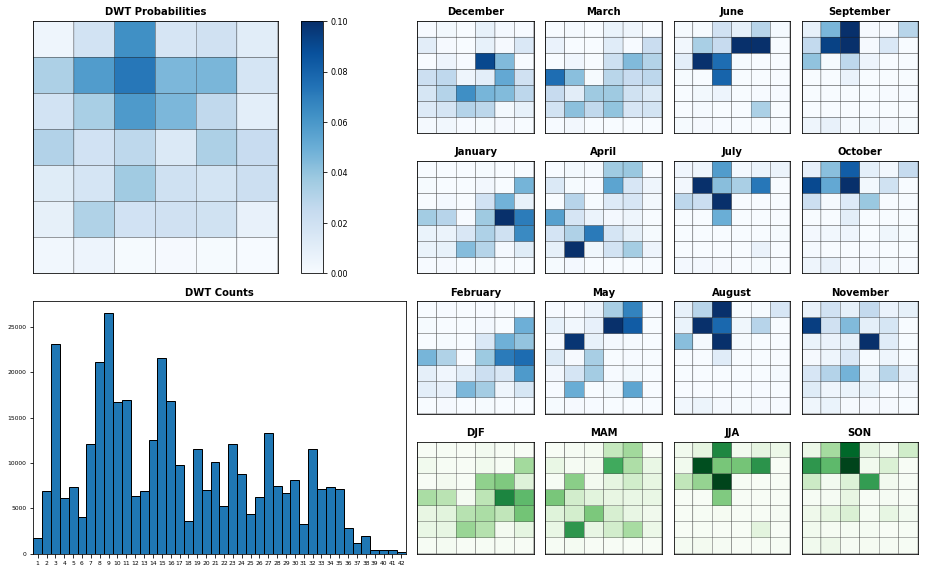

In [12]:
# Plot Simulated DWTs probabilities (with TCs DWTs)

bmus_sim = DWT_sim.isel(n_sim=0).evbmus_sims.values[:]
dbmus_sim = DWT_sim.time.values[:]

Plot_DWTs_Probs(bmus_sim, dbmus_sim, alr_num_clusters);


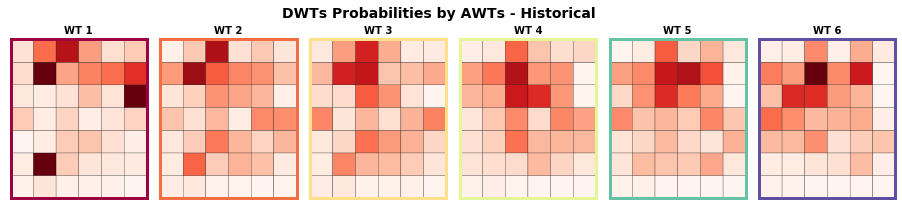

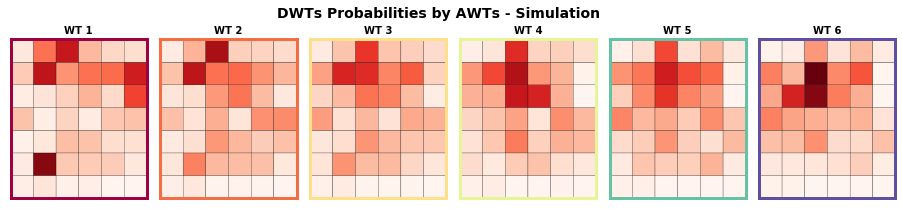

In [13]:
# Plot AWTs/DWTs Probabilities 

# clusters to plot (no TCs)
n_clusters_AWT = 6
n_clusters_DWT = 42
n_sim = 0  # simulation to plot

# Plot AWTs/DWTs Probs - historical
AWT_hist, DWT_hist = db.Load_AWTs_DWTs_Plots_hist()
AWT_bmus = AWT_hist.bmus.values[:]
DWT_bmus = DWT_hist.bmus.values[:]

Plot_Probs_WT_WT(
    AWT_bmus, DWT_bmus, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'DWTs Probabilities by AWTs - Historical'
);

# Plot AWTs/DWTs sim - simulated
AWT_sim, DWT_sim = db.Load_AWTs_DWTs_Plots_sim(n_sim=0)
AWT_bmus = AWT_sim.bmus.values[:]
DWT_bmus = DWT_sim.bmus.values[:]

Plot_Probs_WT_WT(
    AWT_bmus, DWT_bmus, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'DWTs Probabilities by AWTs - Simulation'
);
